# TP CLUSTERING DANS UN BUT DE SEGMENTATION

# Sommaire

1. [Import](#sect1)
2. [Réduction de dimension via une ACP](#sect2)
3. [Clustering Mixte](#sect3)
4. [Portraits Robots](#sect4)


In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
os.chdir("/home/jupyter/python_ml/data")

# 1. Import <a name="sect1"></a> 

## LES DONNEES
Housing data lien : https://www.kaggle.com/apratim87/housingdata/version/1#housingdata.csv


Variables dans l'ordre : 

- **CRIM** per capita crime rate by town 
- **ZN** proportion of residential land zoned for lots over 25,000 sq.ft. 
- **INDUS** proportion of non-retail business acres per town 
- **CHAS** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
- **NOX** nitric oxides concentration (parts per 10 million) 
- **RM** average number of rooms per dwelling 
- **AGE** proportion of owner-occupied units built prior to 1940 
- **DIS** weighted distances to five Boston employment centres 
- **RAD** index of accessibility to radial highways 
- **TAX** full-value property-tax rate per $10,000 
- **PTRATIO** pupil-teacher ratio by town 
- **LSTAT** ratio de lower status of the population 
- **MEDV** Median value of owner-occupied homes en milliers de dollars


In [19]:
housing = pd.read_csv('housingdata.csv',header=0,index_col=False,sep=',',
names=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"])

In [20]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
1,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
3,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7
4,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,12.43,22.9


In [21]:
housing.shape

(504, 13)

In [22]:
housing.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object

#### Transformation des données au bon format et regroupement par classe

In [23]:
housing['CHAS']=housing['CHAS'].astype(bool)

In [26]:
stats = housing.describe(include="all")
stats

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,504.000000,504.000000,504.000000,504,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.627796,11.373016,11.162361,NaN,0.554898,6.283788,68.561111,3.792132,9.581349,408.789683,18.463095,12.675258,22.531746
std,8.615632,23.361404,6.860259,NaN,0.116042,0.703867,28.200606,2.109202,8.709660,168.633955,2.164467,7.145309,9.215044
min,0.009060,0.000000,0.460000,NaN,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,NaN,0.449000,5.884750,44.850000,2.097050,4.000000,279.000000,17.400000,6.990000,16.950000
50%,0.260420,0.000000,9.690000,NaN,0.538000,6.205000,77.500000,3.190950,5.000000,330.000000,19.100000,11.395000,21.200000
75%,3.681942,12.500000,18.100000,NaN,0.624000,6.626000,94.100000,5.212575,24.000000,666.000000,20.200000,16.992500,25.000000


In [27]:
# Créer 3 groupes de valeur des logements <15 , 15-25 et 25+ pour constituer une variable de contrôle à la fin de la segmentation
housing["Valeur_Immo"] = '2.15k-25k$'
housing.loc[housing['MEDV'] >= 25, 'Valeur_Immo'] = '3.>25k$'
housing.loc[housing['MEDV'] <15, 'Valeur_Immo'] = '1.<15k$'
housing['Valeur_Immo']=housing['Valeur_Immo'].astype('category')
housing['Valeur_Immo'].describe()

count            504
unique             3
top       2.15k-25k$
freq             278
Name: Valeur_Immo, dtype: object

# 2. REDUCTION DE DIMENSIONS AVEC ACP <a name="sect2" ></a>

In [28]:
# ACP sur les var numérique et doit être appliquée sur des données standardisées
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# CHAS, MEDV ne sont plus des variables qu'on veut projetter et Valeur Immo sera une variable de controle du clustering
X = housing.drop(["CHAS","MEDV","Valeur_Immo"],axis=1)
# on écrase et on standardise
X = StandardScaler().fit_transform(X)

In [31]:
# CALCUL ACP AVEC SKLEARN avec autant de composants que de colonnes avant de filtrer le nombre de composants (=dimensions)
pca_housing = PCA(n_components=X.shape[1]).fit(X)
CP_housing = pca_housing.transform(X)
# projection des 505 villes sur les nouvelles dimensions

In [34]:
# Analyse des différences de projection
X[0]

array([-0.41831909, -0.48731297, -0.5971243 , -0.74096695,  1.2816455 ,
       -0.26483559,  0.55762106, -0.87131776, -0.99004613, -0.30665935,
       -1.21112288])

In [33]:
CP_housing[0]

array([-2.03407190e+00, -8.06249140e-01,  4.69055119e-01, -1.01212446e+00,
        5.55373017e-01,  9.69811771e-02,  4.71298102e-02, -1.90077534e-01,
       -4.84481524e-01,  1.38479648e-01,  2.02844747e-03])

In [36]:
print(pca_housing.explained_variance_ratio_) # 3 composantes expliquent 75% de la variance des données

[0.53695596 0.11604276 0.10463462 0.0733181  0.04896848 0.03606638
 0.02533082 0.0204343  0.01688901 0.01549171 0.00586786]


In [38]:
print(np.cumsum(np.round(pca_housing.explained_variance_ratio_, decimals=4)*100))

[ 53.7   65.3   75.76  83.09  87.99  91.6   94.13  96.17  97.86  99.41
 100.  ]


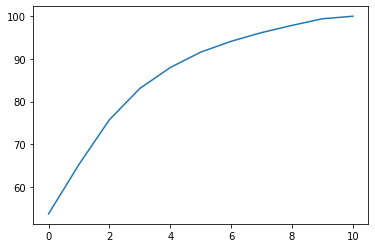

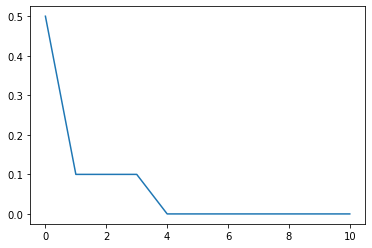

In [39]:
plt.plot(np.cumsum(np.round(pca_housing.explained_variance_ratio_, decimals=4)*100))
plt.figure()
plt.plot(np.round(pca_housing.explained_variance_ratio_, decimals=1))


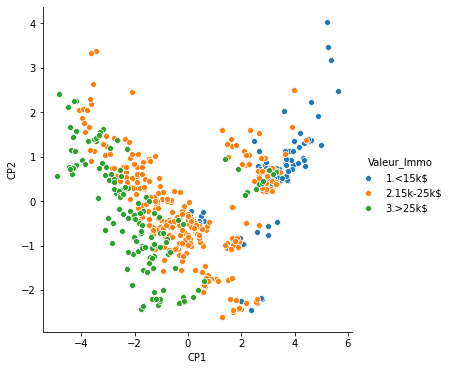

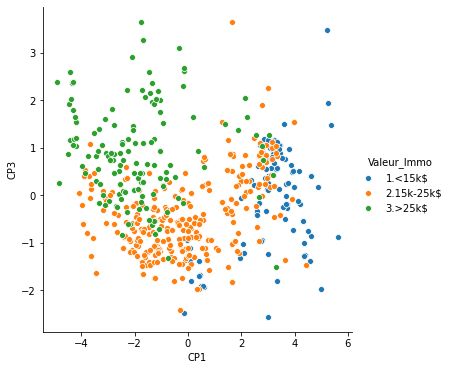

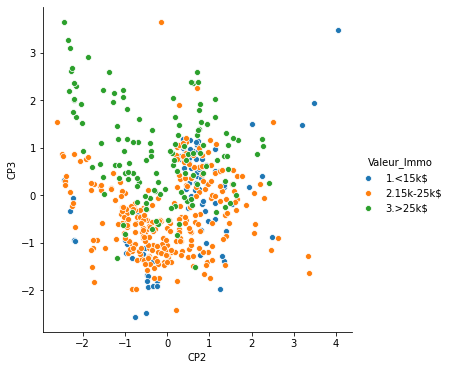

In [41]:
import seaborn as sns
targets = housing.Valeur_Immo.unique()

# Conservation d'uniquement 3 axes et rapprochement avec les données de Valur Immobilière
finalDf = pd.concat([pd.DataFrame(CP_housing[:,0:3], columns = ['CP1', 'CP2','CP3']), housing[["CHAS","MEDV",'Valeur_Immo']]], axis = 1)
sns.pairplot(x_vars='CP1', y_vars='CP2', data=finalDf, hue="Valeur_Immo", height=5)
sns.pairplot(x_vars='CP1', y_vars='CP3', data=finalDf, hue="Valeur_Immo", height=5)
sns.pairplot(x_vars='CP2', y_vars='CP3', data=finalDf, hue="Valeur_Immo", height=5)
# Les 3 catégories de valeur immobilière sont assez corrélées avec l'axe 1 et 3

#### INTERPRETATION DES AXES


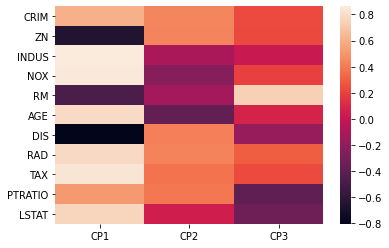

In [45]:
import matplotlib.pyplot as plt
analyse = pd.concat([pd.DataFrame(CP_housing[:,0:3], columns = ['CP1', 'CP2','CP3']), housing[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT"]]], axis = 1)
corr=analyse.corr().loc[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT"],["CP1","CP2","CP3"]]
plt.figure()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.index.values)

# 3. CLUSTERING MIXTE <a name="sect3" ></a>

La classification mixte permet de garder les qualités des méthodes de nuées dynamiques 
et de la classification hiérarchique en contournant leurs inconvénients.
On commence par une k-means pour diminuer la dimension du problème 
puis on fait une classification hiérarchique sur les centroides.

In [47]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy import cluster
from sklearn.cluster import AgglomerativeClustering

In [48]:
# On fait une k-means avec beaucoup de clusters et on récupère les coordonnées des centroides

k_means_cent = KMeans(n_clusters = 25, random_state = 2016).fit(CP_housing[:,0:3])
# barycentres des 25 classes issues de la partition KM
centroides = k_means_cent.cluster_centers_

In [49]:
print(centroides)

[[ 2.14417073  0.40745966  2.05452534]
 [-0.81369318 -1.11863422  0.16160363]
 [-3.69824246  2.43181048 -0.55261227]
 [ 0.00547993 -1.12702295 -0.91018706]
 [-1.49804673 -0.41535776 -0.32845751]
 [ 2.19866764 -2.32292717 -0.02489055]
 [ 4.39606075  1.21378287 -1.15526793]
 [-2.85124737  1.08744882 -0.26633602]
 [-0.65813203 -2.19805703  2.16019913]
 [-4.39550961  0.80303321  2.07299902]
 [ 0.21044818 -0.42057914 -1.59312929]
 [ 4.08685348  1.39146819  0.41894534]
 [ 1.94218655 -0.99918434 -0.99105527]
 [-1.91987073  0.56029713 -0.92522466]
 [-1.05495263 -0.08524955 -1.16340812]
 [-3.75496635  1.41607735  0.77583683]
 [ 0.76731215 -1.94300616  0.63782415]
 [-2.06622697 -0.86293942  1.06540221]
 [ 1.99296895  1.17288666  0.36698992]
 [ 4.95317525  3.30161729  2.11190763]
 [-1.67632639 -1.64118598  2.53693896]
 [ 3.20967819  0.66423939  0.02599167]
 [ 3.04191995  0.5080017   0.88538438]
 [-2.64876578  0.24113937  0.57455171]
 [ 0.05209324 -0.61517725 -0.58086401]]


{'icoord': [[55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [25.0, 25.0, 43.75, 43.75],
  [15.0, 15.0, 34.375, 34.375],
  [5.0, 5.0, 24.6875, 24.6875],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [80.0, 80.0, 102.5, 102.5],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [235.0, 235.0, 245.0, 245.0],
  [212.5, 212.5, 240.0, 240.0],
  [182.5, 182.5, 226.25, 226.25],
  [160.0, 160.0, 204.375, 204.375],
  [132.5, 132.5, 182.1875, 182.1875],
  [91.25, 91.25, 157.34375, 157.34375],
  [14.84375, 14.84375, 124.296875, 124.296875]],
 'dcoord': [[0.0, 0.8894430177340438, 0.8894430177340438, 0.0],
  [0.0, 1.4484752577272912, 1.4484752577272912, 0.8894430177340438],
  [0.0, 1.824379515062345, 1.824379515062345, 1.4484752577272912],
  [0.0,

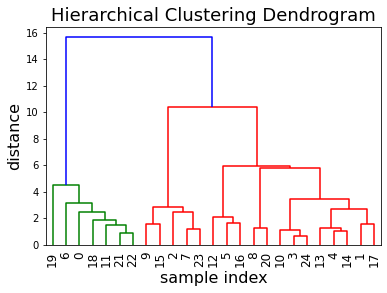

In [50]:
# 25 individus fictifs (barycentres)

# On trace le dendogramme 
# étape préliminaire avec la cluster.hierarchy (CAH): bénéfice de pouvoir représenter
Z = cluster.hierarchy.linkage(centroides, method='ward', metric='euclidean')
plt.figure()

plt.title('Hierarchical Clustering Dendrogram', fontsize=18)

plt.xlabel('sample index', fontsize=16)

plt.ylabel('distance', fontsize=16)
cluster.hierarchy.dendrogram(Z, leaf_font_size=12, leaf_rotation=90.) 


In [51]:
# etape partitionner par rapport au nombre = 3 ou 4
# On peut ensuite réaliser le clustering à l'aide de scikit-learn
hac_cent = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hac_cent.fit(centroides)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

In [57]:
# On récupère le cluster assigné lors du K-means puis lors du CAH pour avoir un cluster final pour chaque observation
kmeans_cent_df = pd.DataFrame(k_means_cent.labels_, columns = ['K-means_cent']).reset_index()
kmeans_cent_df.head()

,index,K-means_cent
0,0,17
1,1,23
2,2,23
3,3,4
4,4,4


In [59]:
kmeans_cent_df['K-means_cent'].unique()

array([17, 23,  4,  1, 10, 14, 24, 15, 13,  7,  2,  3, 12,  5, 16,  8,  9,
       20, 22, 21,  0,  6, 11, 19, 18], dtype=int32)

In [56]:
hac_cent_df = pd.DataFrame(hac_cent.labels_, columns = ['Typologie']).reset_index()
hac_cent_df

,index,Typologie
0,0,1
1,1,0
2,2,2
3,3,0
4,4,0
5,5,3
6,6,1
7,7,2
8,8,0
9,9,2


In [60]:
cluster_cent = pd.merge(kmeans_cent_df, hac_cent_df, left_on=['K-means_cent'], right_on=['index'], how='left')
cluster_cent = cluster_cent.drop(['K-means_cent','index_y'], axis =1)

In [62]:
print(cluster_cent['Typologie'].value_counts())
print(cluster_cent['Typologie'].value_counts(normalize=True))


0    238
1    132
2     85
3     49
Name: Typologie, dtype: int64
0    0.472222
1    0.261905
2    0.168651
3    0.097222
Name: Typologie, dtype: float64


In [65]:
# Jointure finale avec tous les 
typologie = pd.merge(left=housing, right=cluster_cent, how='inner',left_index=True, right_index=True)

# 4. Portraits Robots <a name="sect4" ></a> 

In [71]:
#Pour chaque cluster, on calcule la moyenne des variables quantitatives
# et la proportion des variables qualitatives. On peut ainsi voir en quels domaines les clusters se différencient. Ci-dessous le portrait robot de la classification mixte :

# Variables quanti : moyenne de la variable
# le index =false permet que le resultat reprenne bien les var en group by
stats=typologie.groupby(['Typologie'])[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"]].mean()
stats

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
Typologie,,,,,,,,,,,,,
0,0.307778,4.537815,7.864496,0.075630,0.507486,6.351983,65.064286,4.043694,4.617647,300.210084,18.225630,10.757899,24.525630
1,12.759291,0.000000,18.100000,0.060606,0.672417,6.022152,89.805303,2.061254,24.000000,666.000000,20.200000,18.600606,16.403788
2,0.062739,54.729412,3.596824,0.047059,0.423741,6.758753,29.724706,6.886039,4.105882,302.717647,16.928235,5.949176,29.325882
3,1.338756,0.000000,21.615306,0.102041,0.696122,5.833449,95.685714,1.866053,4.346939,427.285714,17.600000,17.693673,17.569388


In [73]:
# Variables quali : proportion de la variable dans chaque catégorie
pd.crosstab(typologie['Typologie'], typologie['CHAS'], normalize=True)

CHAS,False,True
Typologie,,
0,0.436508,0.035714
1,0.246032,0.015873
2,0.160714,0.007937
3,0.087302,0.009921


In [74]:
pd.crosstab(typologie['Typologie'], typologie['Valeur_Immo'], normalize='index')

Valeur_Immo,1.<15k$,2.15k-25k$,3.>25k$
Typologie,,,
0,0.046218,0.672269,0.281513
1,0.537879,0.378788,0.083333
2,0.000000,0.388235,0.611765
3,0.244898,0.714286,0.040816


#### UTILISER UNE FONCTION DE PORTRAITS ROBOTS

cette fonction permet de calculer les P-values du t-test

In [77]:
os.chdir("/home/jupyter/python_ml/modules/")
from portraits_robots_quanti import portraits_robot_quanti
from pouvoir_discriminant import pouvoir_discriminant

In [81]:
stats=portraits_robot_quanti(typologie, 'Typologie', ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"])
# Pour chaque variable on a la moyenne de la variable par classe de la typologie et la pvalue associée
stats.sort_values('index')

,index,VARIABLE,p-value_0,p-value_1,p-value_2,p-value_3,y_0,y_1,y_2,y_3,y_All
3,0.0,CRIM,0.0,0.0,0.000025,0.050207,0.307778,12.759291,0.062739,1.338756,3.627796
13,1.0,ZN,0.0,0.0,0.0,0.000313,4.537815,0.000000,54.729412,0.000000,11.373016
5,2.0,INDUS,0.0,0.0,0.0,0.0,7.864496,18.100000,3.596824,21.615306,11.162361
2,3.0,CHAS,0.606188,0.642753,0.374238,0.345805,0.075630,0.060606,0.047059,0.102041,0.069444
8,4.0,NOX,0.0,0.0,0.0,0.0,0.507486,0.672417,0.423741,0.696122,0.554898
11,5.0,RM,0.039521,0.000001,0.0,0.000002,6.351983,6.022152,6.758753,5.833449,6.283788
1,6.0,AGE,0.008331,0.0,0.0,0.0,65.064286,89.805303,29.724706,95.685714,68.561111
4,7.0,DIS,0.011178,0.0,0.0,0.0,4.043694,2.061254,6.886039,1.866053,3.792132
10,8.0,RAD,0.0,0.0,0.0,0.000008,4.617647,24.000000,4.105882,4.346939,9.581349
12,9.0,TAX,0.0,0.0,0.0,0.419602,300.210084,666.000000,302.717647,427.285714,408.789683


In [86]:
# Fonction qui calcule pour chaque variable numérique si la typologie explique bien leur variance
# VB = Variance Between
# VW = Variance Within
# VT = Variance Totale
# Tx* = Taux des variances par rapport à la variance Totale
# Calinski = Statistique de Calinski-HaraBascz (Plus c'est élevée plus la variable joue en la faveur de la variance Between)

pouvoirDiscrimant=pouvoir_discriminant(typologie, 'Typologie', ["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"])
pouvoirDiscrimant

,Variable,VB,VW,VT,Calinski,TxVarWithin,TxVarBetween
7,RAD,3.719731e+04,9.593550e+02,3.815666e+04,6462.208185,2.51,97.49
8,TAX,1.251177e+07,1.792245e+06,1.430402e+07,1163.510471,12.53,87.47
2,INDUS,1.916085e+04,4.511911e+03,2.367276e+04,707.787832,19.06,80.94
3,NOX,4.797453e+00,1.975860e+00,6.773313e+00,404.672219,29.17,70.83
1,ZN,1.943119e+05,8.020294e+04,2.745149e+05,403.792235,29.22,70.78
6,DIS,1.405947e+03,8.317660e+02,2.237713e+03,281.719211,37.17,62.83
5,AGE,2.267380e+05,1.732849e+05,4.000229e+05,218.078218,43.32,56.68
10,LSTAT,1.058889e+04,1.509199e+04,2.568089e+04,116.937191,58.77,41.23
0,CRIM,1.496714e+04,2.237011e+04,3.733725e+04,111.511452,59.91,40.09
9,PTRATIO,6.483877e+02,1.708126e+03,2.356514e+03,63.265017,72.49,27.51


## Réaffection - ***Optionnel***


Dans cette section, il s’agit de proposer des techniques d’affectation à une segmentation pré-existante et dont nous possédons un échantillon : nous avons des observations sur des individus dont nous connaissons le segment. On est ici dans un cadre de classification supervisée.

On commence par séparer notre base en deux : une partie pour apprendre le lien entre les variables explicatives et la cible (la classe d’appartenance du client : ici la classification mixte), et une autre sur laquelle on évalue la qualité de la méthode d’affectation - principe de ne pas être juge et partie.

On choisit la taille respective des bases - ici 75% pour l’apprentissage - , puis on tire 75% des lignes au hasard que l’on affecte à la base train, le reste étant affecté à test.


In [90]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(typologie[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT"]],typologie['Typologie'],test_size = 0.25, random_state = 42)

In [92]:
# Plus proches voisins (Nouvelles méthodes par exemple)

# On cherche les plus proches voisins de chaque individu et on lui affecte la classe majoritaire parmi ses voisins. 
# Le paramètre de la méthode est le nombre K de voisins - ici K = 8.
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [93]:
# ech test
y_pred_test = knn.predict(X_test)

In [94]:

#La qualité de la méthode se lit sur la matrice de confusion. Cette méthode est utilisée sur les variables quantitatives.
print(pd.crosstab(y_pred_test, y_test,normalize='index'))
print(pd.crosstab(y_pred_test, y_test,normalize='columns'))

Typologie         0         1         2         3
row_0                                            
0          0.909091  0.000000  0.077922  0.012987
1          0.000000  0.941176  0.000000  0.058824
2          0.200000  0.000000  0.800000  0.000000
3          0.000000  0.000000  0.000000  1.000000
Typologie         0    1         2      3
row_0                                    
0          0.972222  0.0  0.428571  0.125
1          0.000000  1.0  0.000000  0.250
2          0.027778  0.0  0.571429  0.000
3          0.000000  0.0  0.000000  0.625


In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred_test)

0.9126984126984127